In [1]:
import subprocess
import os
import shutil
import warnings

warnings.filterwarnings("ignore")
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import toolsets.spectra_operations as so
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
import time
import numpy as np
import sys
sys.path.append('yuanyue_code')

import re
import pandas as pd

import spectral_entropy as se

import toolsets.denoising_related_functions as de
import pandas as pd
import toolsets.ms2_spectra_plotter as ms2plotter
%load_ext autoreload
%autoreload 2
import toolsets.mass_to_formula as mtf
import toolsets.precursor_matching as pm
import toolsets.mass_recalibration as mr
# import requests
# import numpy as np

Compile the cython code is highly recommended!
i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [5]:
from toolsets.search import num_search

In [2]:
hilic = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/libgen2.0_hilic.csv")
pfp = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD/libgen2.0_pfp.csv")

In [10]:
all = pd.concat([pfp, hilic], axis=0)

In [11]:
all.head()

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_Name,...,reference_adduct,reference_precursor_mz,key,comments,peaks_recalibrated,diff_raw,diff_recalibrated,peaks_recalibrated_denoised,explained_intensity,max_unassigned_peak_intensity
0,207,155.033529,1,0.862997,2085.0,0.617400,127.05482\t2.237659\n128.06293\t5.889224\n129....,186,19,PYROCATECHUIC ACID,...,[M+H]+,155.0339,GLDQAMYCGOIJDV-UHFFFAOYSA-N[M+H]+,recalibrateddenoised,127.05502\t2.237659\n128.063129\t5.889224\n129...,-0.000371,-0.000181,127.05502\t2.237659\n136.015147\t3.731481\n137...,84.65354,5.889224
1,397,271.061066,1,0.406893,2137.0,1.208467,126.046478\t11.440678\n127.057152\t26.165256\n...,288,107,Apigenin,...,[M+H]+,271.0601,KZNIFHPLKGYRTM-UHFFFAOYSA-N[M+H]+,recalibrateddenoised,126.046678\t11.440678\n127.057352\t26.165256\n...,0.000966,0.001116,126.046678\t11.440678\n127.057352\t26.165256\n...,77.55162,67.584750
2,904,289.198404,1,0.186737,1163.0,2.516600,50.014942\t5.663288\n51.022358\t16.923754\n52....,465,438,2-decyl-3-hydroxypentanedioic acid,...,[M+H]+,289.2010,KOLGVIJQEZBWIQ-UHFFFAOYSA-N[M+H]+,recalibrateddenoised,50.015168\t5.663288\n51.022584\t16.923754\n52....,-0.002596,-0.002452,50.015168\t5.663288\n51.022584\t16.923754\n52....,99.57359,3.746144
3,837,311.181980,1,0.740417,16090.0,2.289467,126.045433\t2.053669\n127.055359\t11.007667\n1...,433,402,2-decyl-3-hydroxypentanedioic acid,...,[M+Na]+,311.1829,KOLGVIJQEZBWIQ-UHFFFAOYSA-N[M+Na]+,recalibrateddenoised,126.045633\t2.053669\n127.055559\t11.007667\n1...,-0.000920,-0.000784,126.045633\t2.053669\n127.055559\t11.007667\n1...,96.09716,16.757941
4,803,303.122302,1,0.995707,645013.0,2.237450,118.04487\t1.002273\n119.05082\t2.234901\n131....,428,373,"1-(2,4-dihydroxyphenyl)-2-(3,5-dimethoxyphenyl...",...,[M+H]+,303.1227,TURHNAJJDDIVGC-UHFFFAOYSA-N[M+H]+,recalibrateddenoised,118.045073\t1.002273\n119.051022\t2.234901\n13...,-0.000398,-0.000259,118.045073\t1.002273\n119.051022\t2.234901\n13...,99.43046,2.826807


In [18]:
good_quality = num_search(all, "explained_intensity",90, ">", inclusion=True)
# good_quality = num_search(good_quality, "max_unassigned_peak_intensity", 20, "<", inclusion=True)

In [19]:
len(good_quality['reference_InChIKey'].unique())

1784

In [16]:
len(all['reference_InChIKey'].unique())

1907

In [20]:
1907-1784

123

In [13]:
good_quality.shape

(3061, 25)

In [14]:
all.shape

(3482, 25)

# pie chart

In [4]:
clasifier_result = pd.read_csv("data/classyfire_20220627162530.csv")

In [5]:
clasifier_result = clasifier_result.dropna(subset=['Class'])

In [11]:
class_results = clasifier_result['Class'].value_counts().rename_axis('Class').reset_index(name='counts')

In [28]:
sum(class_results.iloc[0:15]['counts'])

1321

In [27]:
class_results['counts'].sum()

1886

In [35]:
labels = []
for i in range(0,15):
    labels.append(class_results.iloc[i]['Class']+' '+str(np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1))+ '%')

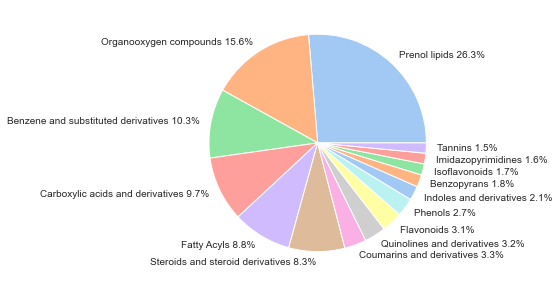

In [42]:
fig, ax = plt.subplots(
    figsize = (10, 5)
                      )
# labels=[f'{class_results.iloc[i]['Class']} {np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1)}%' for i in range(0,15)]
colors = sns.color_palette('pastel')[0:15]
plt.pie(class_results.iloc[0:15]['counts'], labels = labels,colors = colors
        # ,autopct='%.0f%%'
        )
# plt.show()
plt.savefig('data/piechart.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [4]:
data = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD/good_quality.csv")

In [5]:
len(data['InChIKey'].unique())

1859

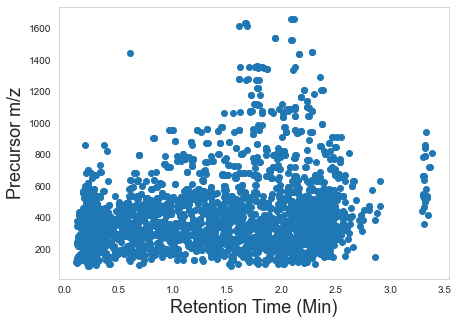

In [6]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
plt.scatter(data['RETENTIONTIME'], data['ExactMass'])
# ax= sns.histplot(data=data, x="normalized_entroy_denoised", multiple="stack", kde = True,
#                  # hue="evaluations"
#                  )
# ax.yaxis
# plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Retention Time (Min)", fontsize = 18)
ax.set_ylabel("Precursor m/z", fontsize = 18)
ax.grid(False)
# plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
plt.savefig('data/rt_exactmass.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [7]:
data.head()

,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,Average_mz,...,intensity,mix_label,Ion_mode,msms_recalibrated,diff_raw,diff_recalibrated,msms_r_u_d,explained_intensity,max_unassigned_intensity,evaluations
0,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+H]+,141.054625,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+H]+,MS2,0.305,141.05440,...,17095,PFPpos_P N 32_EAD,P,50.016142\t736.0\n51.025053\t1515.0\n52.030624...,-0.000225,-0.000019,50.016142\t11.3879\n51.025053\t23.441126\n52.0...,0.971534,0.866471,good quality
1,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.101910,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,2.582,156.10075,...,19353,PFPpos_P N 32_EAD,P,50.014812\t66.0\n51.023723\t134.0\n51.939574\t...,-0.001160,-0.000031,50.014812\t5.602716\n51.023723\t11.375212\n52....,0.909739,17.147708,good quality
2,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+Na]+,163.036565,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+Na]+,MS2,2.276,163.03870,...,4983558,PFPpos_P N 32_EAD,P,105.037568\t22.0\n115.046157\t35.0\n115.053517...,0.002135,-0.000037,105.037568\t0.11217\n115.046157\t0.178453\n115...,0.880000,11.038597,good quality
3,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+NH4]+,173.128450,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+NH4]+,MS2,2.237,173.13094,...,43595,PFPpos_P N 32_EAD,P,113.986286\t22.0\n115.054537\t858.0\n116.06021...,0.002490,-0.000046,113.038645\t1.551481\n115.054412\t39.862994\n1...,0.780880,100.000000,flagged: high unassigned intensity
4,4-nitroquinoline 1-oxide,YHQDZJICGQWFHK-UHFFFAOYSA-N[M+H]+,191.045123,YHQDZJICGQWFHK-UHFFFAOYSA-N,C9H6N2O3,190.03784,[M+H]+,MS2,0.943,191.04510,...,1190323,PFPpos_P N 32_EAD,P,50.014112\t679.0\n51.023013\t2218.0\n52.019374...,-0.000023,-0.000061,50.014112\t3.456174\n51.023013\t11.28983\n52.0...,0.978842,1.364145,good quality


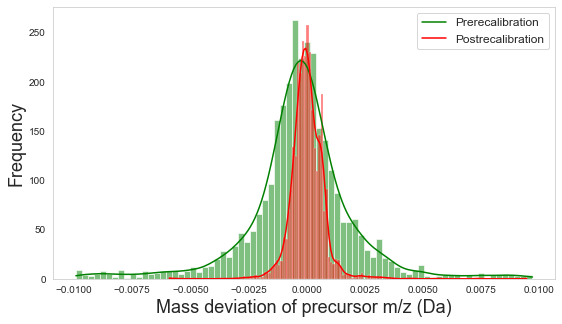

In [42]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
ax= sns.histplot(data=data, x="diff_raw", multiple="stack", kde = True, color = 'green')
ax = sns.histplot(data=data, x="diff_recalibrated", multiple="stack", kde = True,color = 'red')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Mass deviation of precursor m/z (Da)", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Prerecalibration","Postrecalibration"], loc = 'upper right',fontsize=12)
plt.savefig('data/recalibration_kde.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [9]:
data['diff_raw'].describe()

count    3077.000000
mean       -0.000272
std         0.002366
min        -0.009925
25%        -0.001164
50%        -0.000246
75%         0.000716
max         0.009710
Name: diff_raw, dtype: float64

In [10]:
data['diff_recalibrated'].describe()

count    3077.000000
mean        0.000025
std         0.000732
min        -0.005916
25%        -0.000350
50%        -0.000001
75%         0.000395
max         0.009460
Name: diff_recalibrated, dtype: float64

In [11]:
data['diff_recalibrated'].quantile(0.975)-data['diff_recalibrated'].quantile(1-0.975)

0.0026413345690910793

In [12]:
data['diff_raw'].quantile(0.975)-data['diff_raw'].quantile(1-0.975)

0.010933059999967867

In [19]:
data_scatter = data.loc[data['diff_recalibrated']==data['diff_raw']]

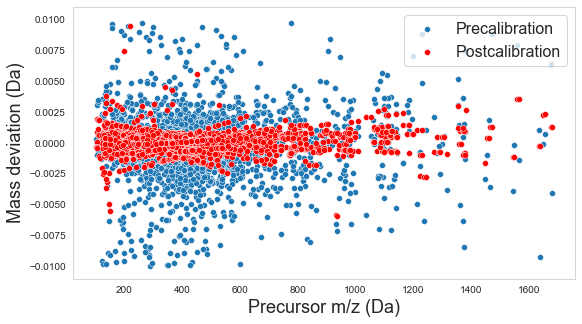

In [41]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
ax= sns.scatterplot(data=data_scatter, x=data['PRECURSORMZ'], y=data['diff_raw'])
ax= sns.scatterplot(data=data_scatter, x=data['PRECURSORMZ'], y=data['diff_recalibrated'],color = 'red')

# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Precursor m/z (Da)", fontsize = 18)
ax.set_ylabel("Mass deviation (Da)", fontsize = 18)
ax.set_ylim(-0.011, 0.011)
ax.grid(False)
plt.legend(labels=["Precalibration",'Postcalibration'], loc = 'upper right',fontsize=16)
plt.savefig('data/pre_post_calibration.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [6]:
data_recalibrate['InChIKey'].unique()

array(['QFYYAIBEHOEZKC-UHFFFAOYSA-N', 'HJJPJSXJAXAIPN-UHFFFAOYSA-N',
       'YHQDZJICGQWFHK-UHFFFAOYSA-N', ..., 'YPIGGYHFMKJNKV-UHFFFAOYSA-N',
       'OTKJDMGTUTTYMP-UHFFFAOYSA-N', 'JCQLYHFGKNRPGE-FCVZTGTOSA-N'],
      dtype=object)

In [1]:
(239.16472-0.00054858026)-239.128937

0.03523441973999297

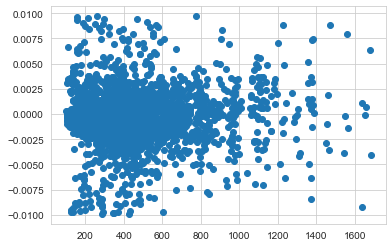

In [38]:
plt.scatter(data_recalibrate['PRECURSORMZ'], data_recalibrate['diff_raw'])

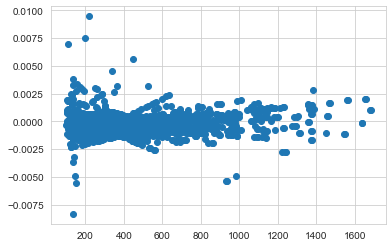

In [39]:
plt.scatter(data_recalibrate['PRECURSORMZ'], data_recalibrate['diff_recalibrated'])

In [20]:
so.normalized_entropy(data.iloc[0]['msms_denoised'])

0.2621969472559028

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

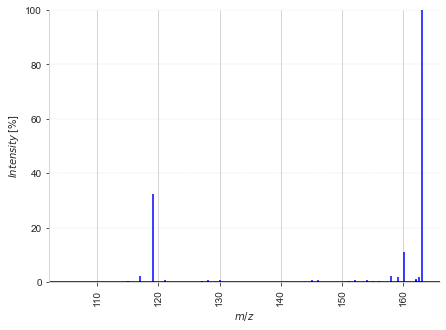

In [33]:
ms2plotter.ms2_plot(data.iloc[2]['msms'])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

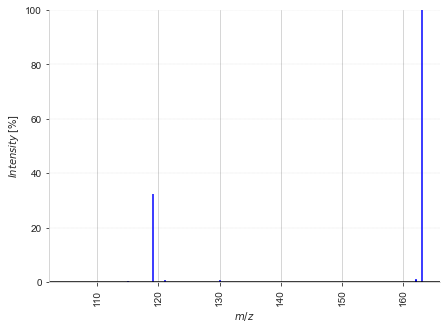

In [31]:

ms2plotter.ms2_plot(data.iloc[2]['msms_denoised'])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

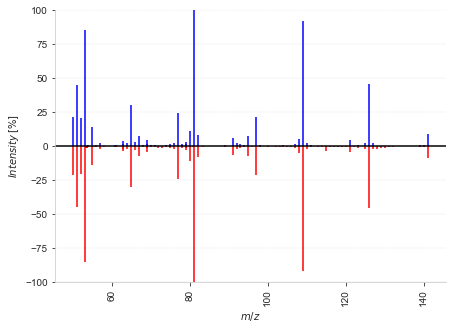

In [30]:
ms2plotter.head_to_tail_plot(data.iloc[0]['msms_denoised'],data.iloc[0]['msms'])

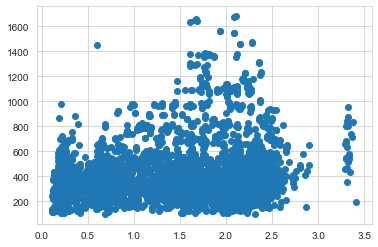

In [11]:
plt.scatter(data['RETENTIONTIME'], data['PRECURSORMZ'])